1


Processing Picture1.jpg


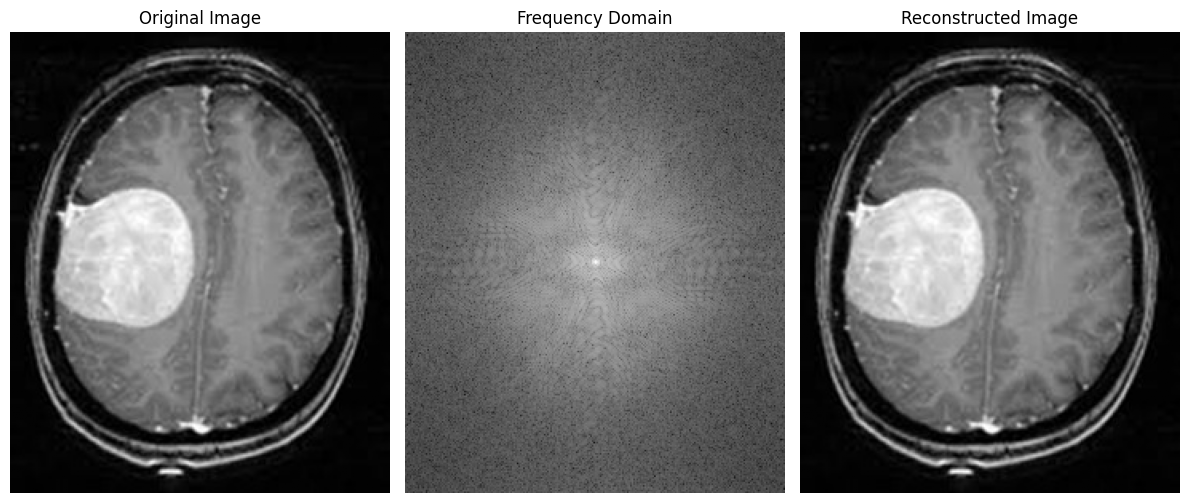


Processing Picture2.jpg


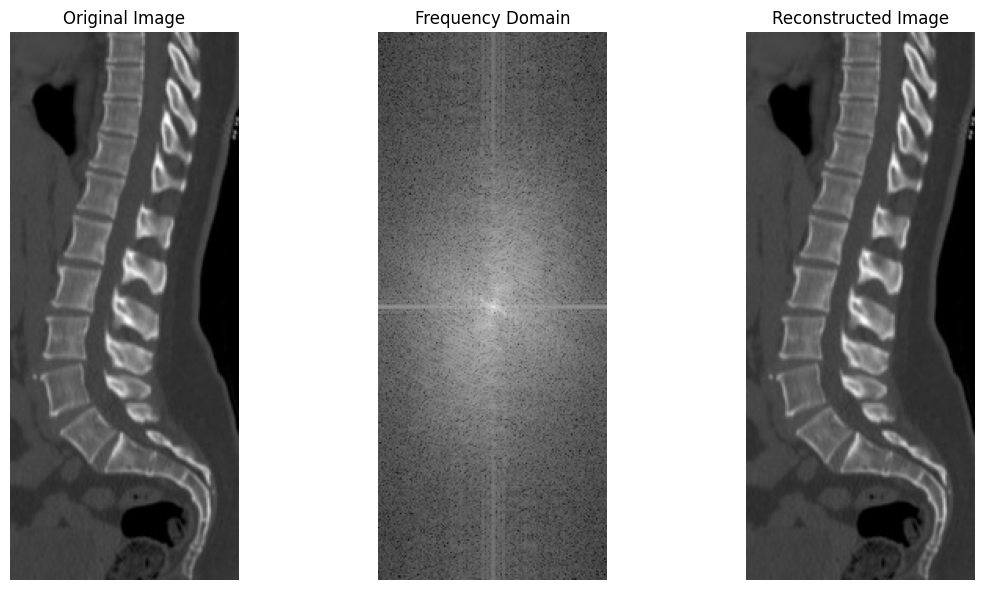


Processing Picture3.jpg


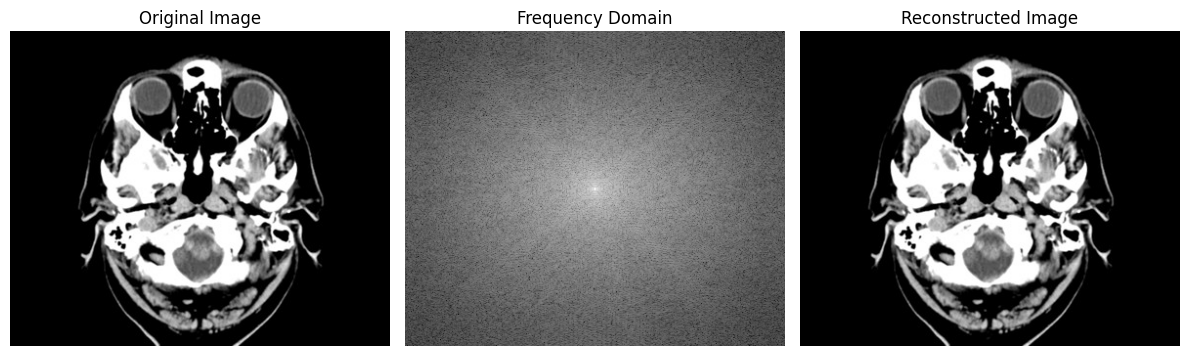


Processing Picture4.jpg


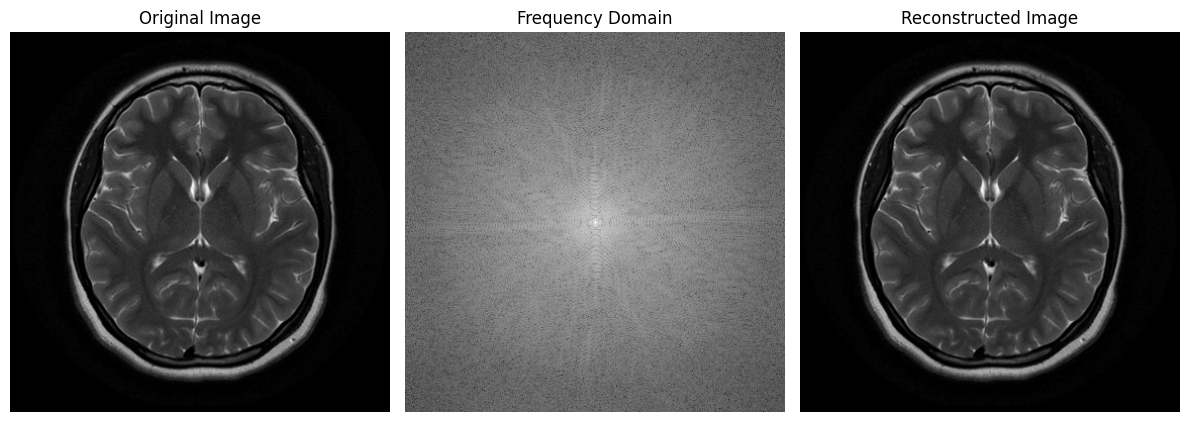


Processing Picture5.jpg


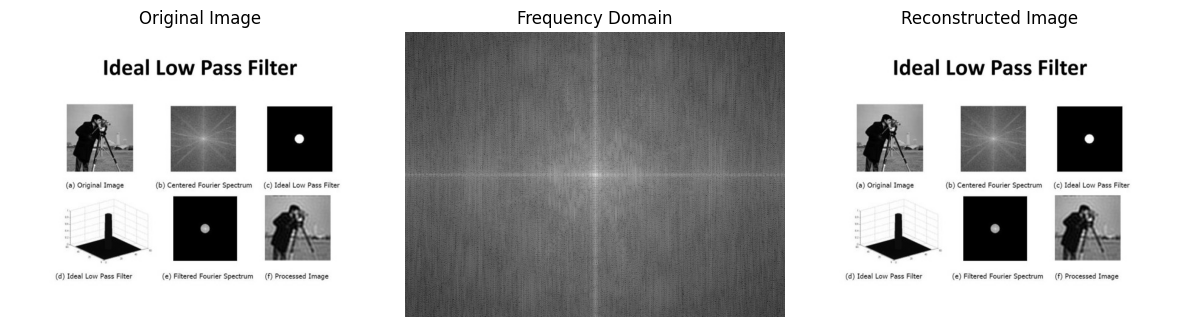

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def apply_fourier_transform(image_path):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift))

    idft_shift = np.fft.ifftshift(dft_shift)
    img_back = np.fft.ifft2(idft_shift)
    img_back = np.abs(img_back)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Frequency Domain')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_back, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(1, 6):
    image_path = f"/content/Picture{i}.jpg"
    print(f"\nProcessing Picture{i}.jpg")
    apply_fourier_transform(image_path)

2

Saving Picture4.jpg to Picture4 (2).jpg

Found 1 images for analysis:
- Picture4 (2).jpg

🚀 PROCESSING IMAGES...

🔍 Analyzing Picture4 (2).jpg...


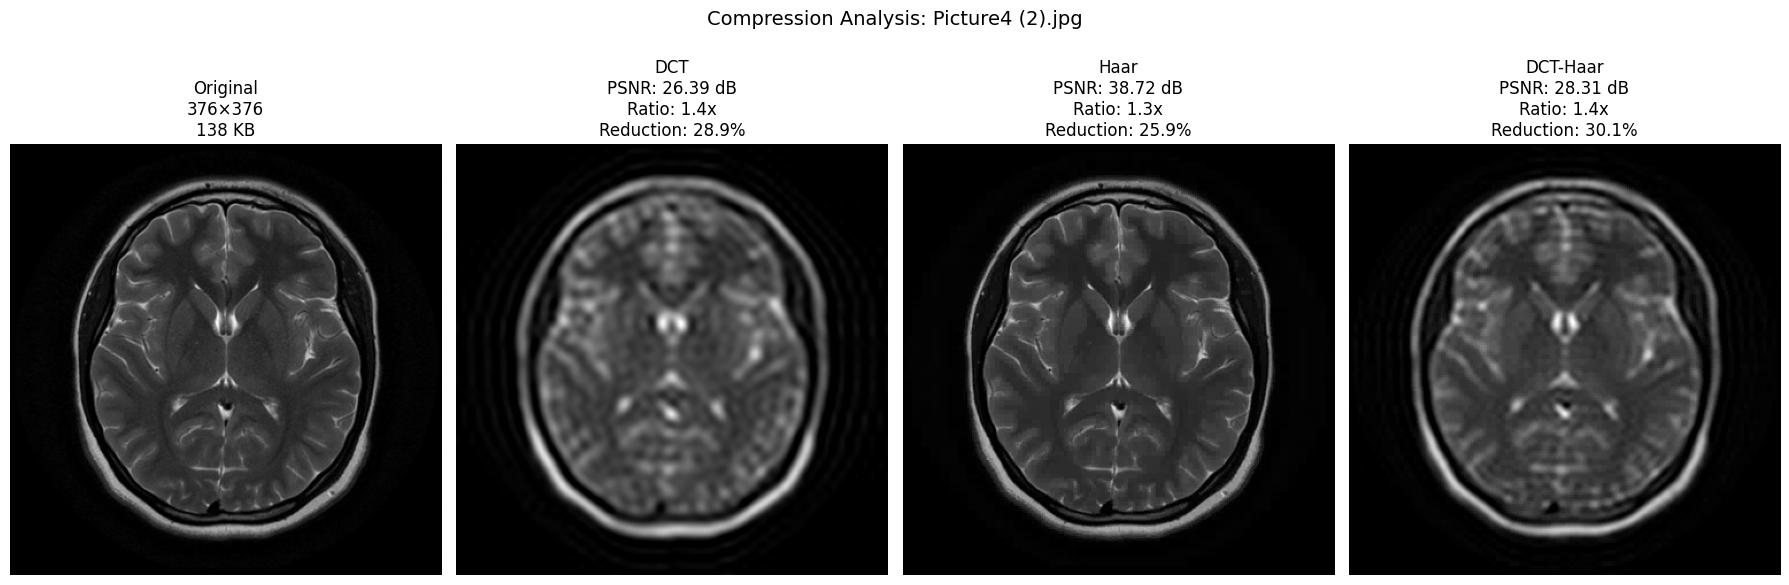


📊 FINAL COMPARISON SUMMARY

📈 Average Performance Across All Images:
Method     PSNR (dB)       Comp Ratio      Images Tested  
DCT        26.39           1.41            1              
Haar       38.72           1.35            1              
DCT-Haar   28.31           1.43            1              

🏆 Best Methods:
- Highest Quality (PSNR): Haar (38.72 dB)
- Best Compression: DCT-Haar (ratio 1.43x)

💡 Key Observations:
1. DCT: Fastest but may show blocking artifacts at high compression
2. Haar: Better edge preservation but can cause ringing effects
3. DCT-Haar: Balanced approach combining both strengths


In [10]:

"""Image Compression Comparison: DCT vs Haar vs DCT-Haar.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1YH7YH6y5G8D7Z4Q4Q4Q4Q4Q4Q4Q4Q4Q4
"""

import numpy as np
import cv2
import pywt
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import os
from google.colab import files

uploaded = files.upload()
image_paths = [f"/content/{name}" for name in uploaded.keys()
              if name.lower().endswith(('.jpg', '.jpeg', '.png'))]

if not image_paths:
    raise FileNotFoundError("No valid images found. Please upload JPG/PNG files.")

print(f"\nFound {len(image_paths)} images for analysis:")
for path in image_paths:
    print(f"- {os.path.basename(path)}")

def dct_compress(img, keep_fraction=0.15):
    """DCT compression by keeping top-left coefficients"""
    dct = cv2.dct(np.float32(img)/255.0)
    rows, cols = dct.shape
    dct[int(rows*keep_fraction):, :] = 0
    dct[:, int(cols*keep_fraction):] = 0
    reconstructed = cv2.idct(dct) * 255.0
    return np.clip(reconstructed, 0, 255).astype(np.uint8)

def haar_compress(img, level=3, threshold_percent=90):
    """Haar wavelet compression with thresholding"""
    coeffs = pywt.wavedec2(img, 'haar', level=level)
    arr, slices = pywt.coeffs_to_array(coeffs)
    threshold = np.percentile(np.abs(arr), threshold_percent)
    arr[np.abs(arr) < threshold] = 0
    new_coeffs = pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
    reconstructed = pywt.waverec2(new_coeffs, 'haar')
    return np.clip(reconstructed, 0, 255).astype(np.uint8)

def dct_haar_compress(img, dct_keep=0.2, haar_thresh=85):
    """Hybrid DCT-Haar compression"""

    dct = cv2.dct(np.float32(img)/255.0)
    rows, cols = dct.shape
    dct[int(rows*dct_keep):, :] = 0
    dct[:, int(cols*dct_keep):] = 0

    temp_img = cv2.idct(dct) * 255.0
    coeffs = pywt.wavedec2(temp_img, 'haar', level=2)
    arr, slices = pywt.coeffs_to_array(coeffs)
    threshold = np.percentile(np.abs(arr), haar_thresh)
    arr[np.abs(arr) < threshold] = 0
    new_coeffs = pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
    reconstructed = pywt.waverec2(new_coeffs, 'haar')
    return np.clip(reconstructed, 0, 255).astype(np.uint8)

def calculate_metrics(original, compressed):
    """Calculate PSNR and compression ratio"""
    original_size = original.size
    compressed_size = np.count_nonzero(compressed)
    return {
        'psnr': psnr(original, compressed),
        'compression_ratio': original_size / compressed_size if compressed_size > 0 else float('inf'),
        'size_reduction': f"{(1 - compressed_size/original_size)*100:.1f}%"
    }

def process_image(img_path):
    """Process a single image through all compression methods"""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️ Could not read {os.path.basename(img_path)} - skipping")
        return None

    methods = {
        'DCT': dct_compress(img),
        'Haar': haar_compress(img),
        'DCT-Haar': dct_haar_compress(img)
    }

    results = {}
    for name, compressed in methods.items():
        results[name] = {
            'image': compressed,
            'metrics': calculate_metrics(img, compressed)
        }

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{img.shape[1]}×{img.shape[0]}\n{img.size//1024} KB")
    plt.axis('off')

    for i, (name, data) in enumerate(results.items(), 2):
        plt.subplot(1, 4, i)
        plt.imshow(data['image'], cmap='gray')
        m = data['metrics']
        plt.title(f"{name}\nPSNR: {m['psnr']:.2f} dB\nRatio: {m['compression_ratio']:.1f}x\nReduction: {m['size_reduction']}")
        plt.axis('off')

    plt.suptitle(f"Compression Analysis: {os.path.basename(img_path)}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    return results

all_results = []
print("\n" + "="*60)
print("🚀 PROCESSING IMAGES...")
print("="*60)

for path in image_paths:
    print(f"\n🔍 Analyzing {os.path.basename(path)}...")
    result = process_image(path)
    if result:
        all_results.append(result)

if all_results:
    print("\n" + "="*60)
    print("📊 FINAL COMPARISON SUMMARY")
    print("="*60)

    summary = {
        'DCT': {'psnr': 0, 'ratio': 0, 'count': 0},
        'Haar': {'psnr': 0, 'ratio': 0, 'count': 0},
        'DCT-Haar': {'psnr': 0, 'ratio': 0, 'count': 0}
    }

    for result in all_results:
        for method in summary.keys():
            summary[method]['psnr'] += result[method]['metrics']['psnr']
            summary[method]['ratio'] += result[method]['metrics']['compression_ratio']
            summary[method]['count'] += 1

    print("\n📈 Average Performance Across All Images:")
    print("{:<10} {:<15} {:<15} {:<15}".format('Method', 'PSNR (dB)', 'Comp Ratio', 'Images Tested'))
    for method, data in summary.items():
        avg_psnr = data['psnr'] / data['count']
        avg_ratio = data['ratio'] / data['count']
        print("{:<10} {:<15.2f} {:<15.2f} {:<15}".format(method, avg_psnr, avg_ratio, data['count']))

    best_psnr = max(summary.items(), key=lambda x: x[1]['psnr'])
    best_ratio = max(summary.items(), key=lambda x: x[1]['ratio'])

    print("\n🏆 Best Methods:")
    print(f"- Highest Quality (PSNR): {best_psnr[0]} ({best_psnr[1]['psnr']/best_psnr[1]['count']:.2f} dB)")
    print(f"- Best Compression: {best_ratio[0]} (ratio {best_ratio[1]['ratio']/best_ratio[1]['count']:.2f}x)")

    print("\n💡 Key Observations:")
    print("1. DCT: Fastest but may show blocking artifacts at high compression")
    print("2. Haar: Better edge preservation but can cause ringing effects")
    print("3. DCT-Haar: Balanced approach combining both strengths")
else:
    print("❌ No valid results to analyze - please check your image files")


3

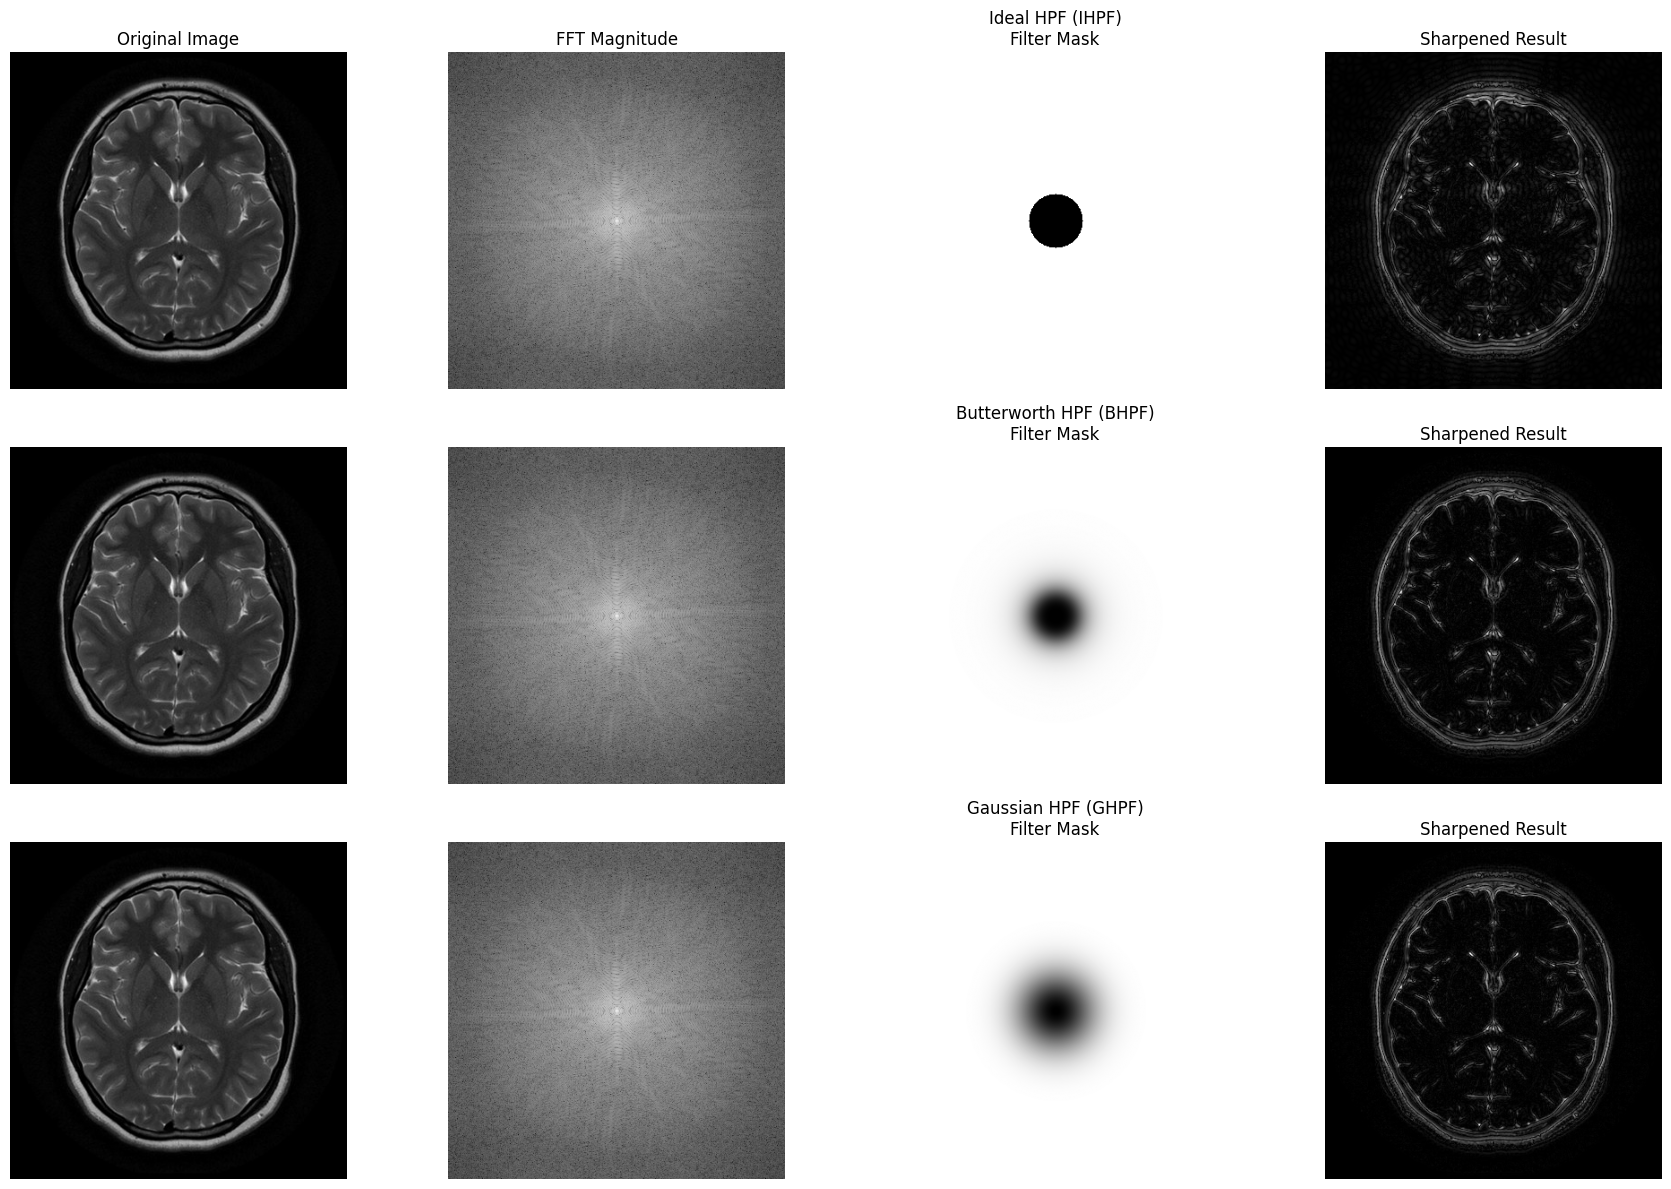


SHARPNESS COMPARISON (Higher is better):
Ideal HPF (IHPF): 299.28
Butterworth HPF (BHPF): 264.13
Gaussian HPF (GHPF): 242.09


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the Brain MRI image (Figure 1)
img_path = '/content/Picture4.jpg'  # Assuming this is your Figure 1
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}. Please verify the path.")

# Fourier Transform
dft = np.fft.fft2(img)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)  # +1 to avoid log(0)

rows, cols = img.shape
center = (rows//2, cols//2)

# Filter functions
def create_ihpf(D0=30):
    mask = np.ones((rows, cols), np.float32)
    cv2.circle(mask, center, D0, 0, -1)
    return mask

def create_bhpf(D0=30, n=2):
    x = np.arange(cols) - center[1]
    y = np.arange(rows) - center[0]
    xx, yy = np.meshgrid(x, y)
    D = np.sqrt(xx**2 + yy**2)
    return 1 - 1/(1 + (D/D0)**(2*n))

def create_ghpf(D0=30):
    x = np.arange(cols) - center[1]
    y = np.arange(rows) - center[0]
    xx, yy = np.meshgrid(x, y)
    D = np.sqrt(xx**2 + yy**2)
    return 1 - np.exp(-(D**2)/(2*D0**2))

# Create filters
filters = {
    'Ideal HPF (IHPF)': create_ihpf(30),
    'Butterworth HPF (BHPF)': create_bhpf(30, 2),
    'Gaussian HPF (GHPF)': create_ghpf(30)
}

# Process and display
plt.figure(figsize=(18, 12))
for i, (name, mask) in enumerate(filters.items(), 1):
    # Apply filter
    filtered_fft = dft_shift * mask
    filtered_magnitude = 20 * np.log(np.abs(filtered_fft) + 1)
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))

    # Display steps
    plt.subplot(3, 4, 4*(i-1)+1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image' if i == 1 else '')
    plt.axis('off')

    plt.subplot(3, 4, 4*(i-1)+2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('FFT Magnitude' if i == 1 else '')
    plt.axis('off')

    plt.subplot(3, 4, 4*(i-1)+3)
    plt.imshow(mask, cmap='gray')
    plt.title(f'{name}\nFilter Mask')
    plt.axis('off')

    plt.subplot(3, 4, 4*(i-1)+4)
    plt.imshow(img_back, cmap='gray')
    plt.title('Sharpened Result')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Quantitative comparison
print("\nSHARPNESS COMPARISON (Higher is better):")
for name, mask in filters.items():
    filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_shift * mask)))
    sharpness = np.mean(cv2.Laplacian(filtered, cv2.CV_64F).var())
    print(f"{name}: {sharpness:.2f}")

4

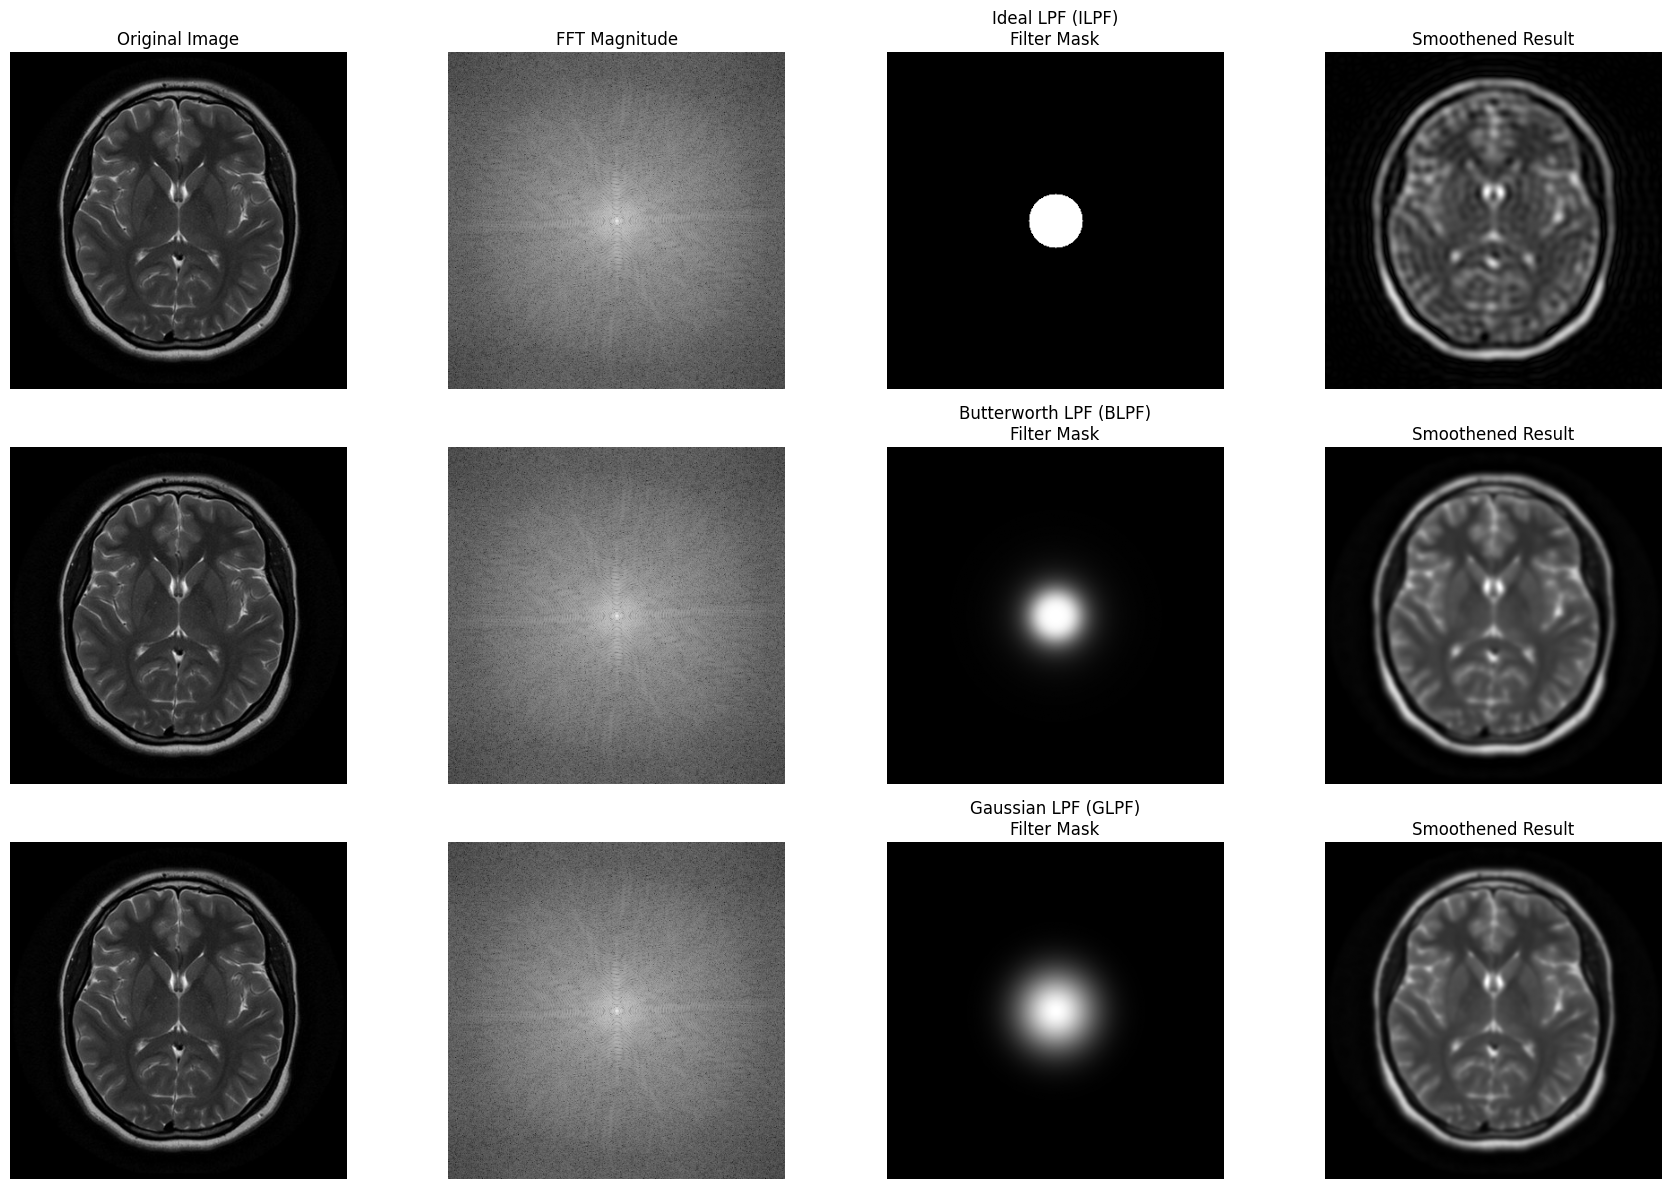


SMOOTHNESS COMPARISON (Lower is better):
Ideal LPF (ILPF): 7.29
Butterworth LPF (BLPF): 3.51
Gaussian LPF (GLPF): 5.57


In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_path = '/content/Picture4.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")

dft = np.fft.fft2(img)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

rows, cols = img.shape
center = (rows//2, cols//2)

def create_ilpf(D0=30):
    mask = np.zeros((rows, cols), np.float32)
    cv2.circle(mask, center, D0, 1, -1)
    return mask

def create_blpf(D0=30, n=2):
    x = np.arange(cols) - center[1]
    y = np.arange(rows) - center[0]
    xx, yy = np.meshgrid(x, y)
    D = np.sqrt(xx**2 + yy**2)
    return 1 / (1 + (D/D0)**(2*n))

def create_glpf(D0=30):
    x = np.arange(cols) - center[1]
    y = np.arange(rows) - center[0]
    xx, yy = np.meshgrid(x, y)
    D = np.sqrt(xx**2 + yy**2)
    return np.exp(-(D**2)/(2*D0**2))

filters = {
    'Ideal LPF (ILPF)': create_ilpf(30),
    'Butterworth LPF (BLPF)': create_blpf(30, 2),
    'Gaussian LPF (GLPF)': create_glpf(30)
}

plt.figure(figsize=(18, 12))
for i, (name, mask) in enumerate(filters.items(), 1):

    filtered_fft = dft_shift * mask
    filtered_magnitude = 20 * np.log(np.abs(filtered_fft) + 1)
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))

    plt.subplot(3, 4, 4*(i-1)+1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image' if i == 1 else '')
    plt.axis('off')

    plt.subplot(3, 4, 4*(i-1)+2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('FFT Magnitude' if i == 1 else '')
    plt.axis('off')

    plt.subplot(3, 4, 4*(i-1)+3)
    plt.imshow(mask, cmap='gray')
    plt.title(f'{name}\nFilter Mask')
    plt.axis('off')

    plt.subplot(3, 4, 4*(i-1)+4)
    plt.imshow(img_back, cmap='gray')
    plt.title('Smoothened Result')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nSMOOTHNESS COMPARISON (Lower is better):")
for name, mask in filters.items():
    filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_shift * mask)))
    roughness = cv2.Laplacian(filtered, cv2.CV_64F).var()
    print(f"{name}: {roughness:.2f}")

5

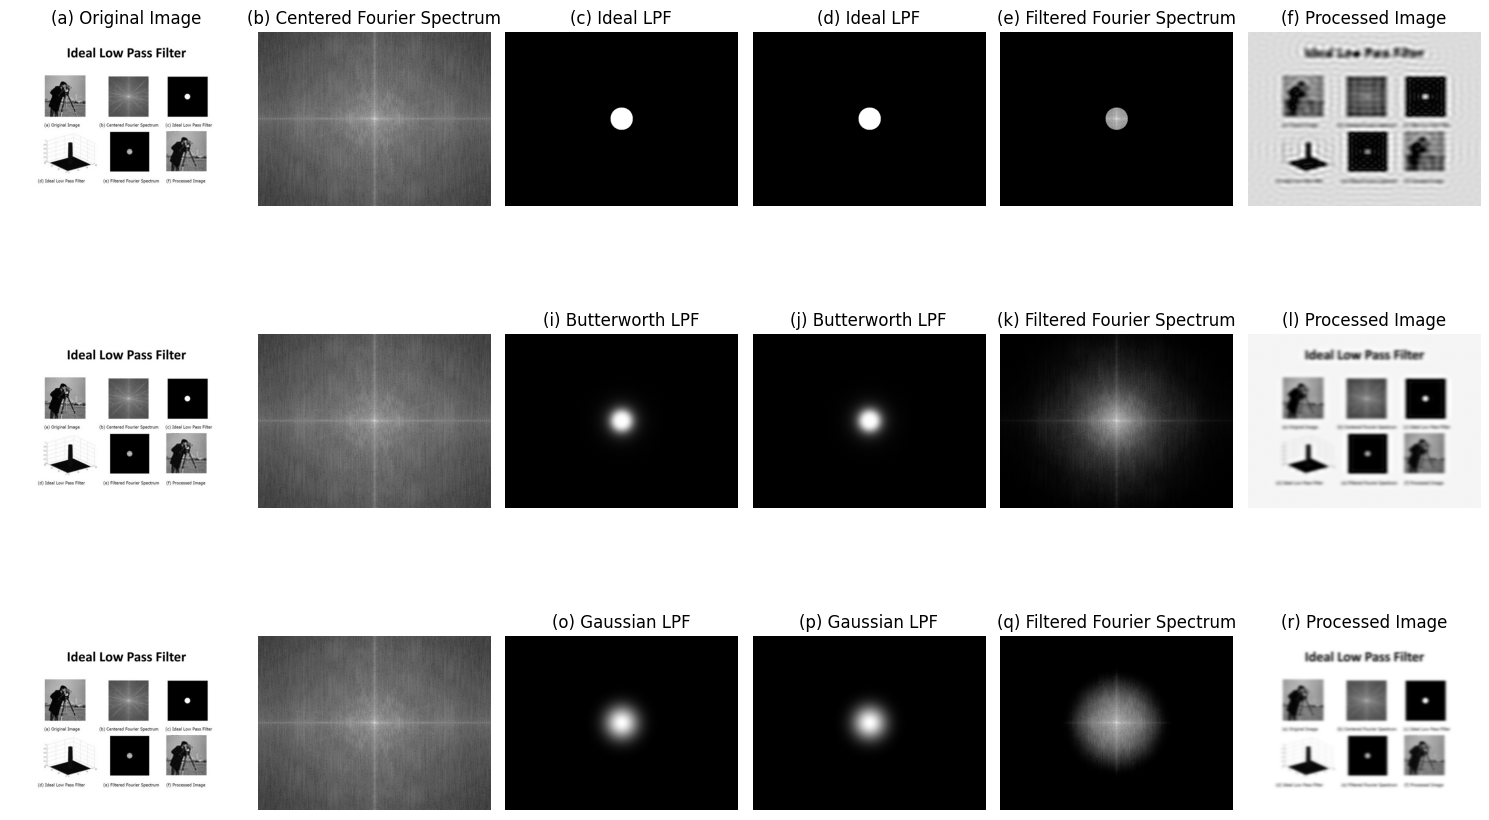


SMOOTHNESS EVALUATION (Lower values are better):
Ideal LPF: 5.29
Butterworth LPF: 2.71
Gaussian LPF: 4.12


In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/content/Picture5.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("Image not found at /content/Picture5.jpg")

dft = np.fft.fft2(img)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

rows, cols = img.shape
crow, ccol = rows//2, cols//2

def ideal_lpf(D0=30):
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), D0, 1, -1)
    return mask

def butterworth_lpf(D0=30, n=2):
    u = np.arange(cols) - ccol
    v = np.arange(rows) - crow
    u, v = np.meshgrid(u, v)
    D = np.sqrt(u**2 + v**2)
    return 1 / (1 + (D/D0)**(2*n))

def gaussian_lpf(D0=30):
    u = np.arange(cols) - ccol
    v = np.arange(rows) - crow
    u, v = np.meshgrid(u, v)
    D = np.sqrt(u**2 + v**2)
    return np.exp(-(D**2)/(2*D0**2))

filters = {
    'Ideal LPF': ideal_lpf(30),
    'Butterworth LPF': butterworth_lpf(30, 2),
    'Gaussian LPF': gaussian_lpf(30)
}

plt.figure(figsize=(15, 10))

for i, (name, mask) in enumerate(filters.items(), 1):

    filtered_fft = dft_shift * mask
    filtered_img = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))

    plt.subplot(3, 6, 6*(i-1)+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'({chr(97+6*(i-1))}) Original Image' if i == 1 else '')
    plt.axis('off')

    plt.subplot(3, 6, 6*(i-1)+2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'({chr(98+6*(i-1))}) Centered Fourier Spectrum' if i == 1 else '')
    plt.axis('off')

    plt.subplot(3, 6, 6*(i-1)+3)
    plt.imshow(mask, cmap='gray')
    plt.title(f'({chr(99+6*(i-1))}) {name}')
    plt.axis('off')

    plt.subplot(3, 6, 6*(i-1)+4)
    plt.imshow(mask, cmap='gray')
    plt.title(f'({chr(100+6*(i-1))}) {name}')
    plt.axis('off')

    plt.subplot(3, 6, 6*(i-1)+5)
    plt.imshow(20*np.log(np.abs(filtered_fft)+1), cmap='gray')
    plt.title(f'({chr(101+6*(i-1))}) Filtered Fourier Spectrum')
    plt.axis('off')

    plt.subplot(3, 6, 6*(i-1)+6)
    plt.imshow(filtered_img, cmap='gray')
    plt.title(f'({chr(102+6*(i-1))}) Processed Image')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nSMOOTHNESS EVALUATION (Lower values are better):")
for name, mask in filters.items():
    filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_shift * mask)))
    roughness = cv2.Laplacian(filtered, cv2.CV_64F).var()
    print(f"{name}: {roughness:.2f}")